<a href="https://colab.research.google.com/github/Sebastian-Frey/Timeseries-Forecasting-leveraging-LLMs/blob/main/2_EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global EDA

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew

vars_to_summarize = ["cpc_week", "impressions_sum", "adclicks_sum", "adcost_sum",
    "n_dev_desktop", "n_dev_mobile", "n_dev_tablet",
    "avg_sim_top25_this_week", "avg_sim_top25_last_week",
    "n_st_branded_search", "n_st_generic_search",
]

rows = []

for col in vars_to_summarize:
    x = df_parquet[col].dropna()

    p01 = x.quantile(0.01)
    p25 = x.quantile(0.25)
    p75 = x.quantile(0.75)
    p99 = x.quantile(0.99)

    rows.append({
        "variable": col,
        "mean": x.mean(),
        "median": x.median(),
        "std": x.std(),
        "min": x.min(),
        "max": x.max(),
        "skew": skew(x),
        "p01": p01,
        "p25": p25,
        "p75": p75,
        "p99": p99,
        "coef_var": x.std() / x.mean()
    })

summary_df = pd.DataFrame(rows).round(4)
summary_df


,variable,mean,median,std,min,max,skew,p01,p25,p75,p99,coef_var
0,cpc_week,2.8627,2.1974,2.5374,0.0071,80.1600,3.3449,0.2564,1.2100,3.7047,12.1297,0.8864
1,impressions_sum,1097.6629,44.0000,14748.4059,1.0000,651814.0000,26.9804,1.0000,12.0000,178.0000,10265.0800,13.4362
2,adclicks_sum,338.4949,16.0000,5694.4657,1.0000,297789.0000,31.0404,1.0000,6.0000,48.0000,1981.3100,16.8229
3,adcost_sum,457.7804,37.6630,6421.6842,0.0071,443869.9479,33.8467,0.5596,12.0692,115.4400,3425.0601,14.0279
4,n_dev_desktop,20.8007,5.0000,170.5039,0.0000,17434.0000,36.8544,0.0000,2.0000,13.0000,182.0000,8.1970
5,n_dev_mobile,25.2189,6.0000,188.7263,0.0000,16026.0000,33.6517,0.0000,3.0000,16.0000,224.0000,7.4835
6,n_dev_tablet,1.7199,0.0000,11.2732,0.0000,467.0000,17.8873,0.0000,0.0000,1.0000,22.0000,6.5546
7,avg_sim_top25_this_week,0.5844,0.6042,0.0870,0.2015,0.8025,-1.4186,0.2987,0.5560,0.6385,0.7217,0.1488
8,avg_sim_top25_last_week,0.5844,0.6043,0.0870,0.2015,0.8025,-1.4191,0.2983,0.5561,0.6385,0.7217,0.1489
9,n_st_branded_search,19.4093,0.0000,236.5392,0.0000,19801.0000,40.7703,0.0000,0.0000,6.0000,205.0000,12.1869


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def trimmed_boxplot(df, col, ax, title_suffix="— Boxplot"):
    """
    Boxplot with grid + robust trimming.
    If the variable has very few distinct values (e.g. 0,1,2) we skip trimming.
    """
    data = df[col].dropna()

    if data.nunique() > 5:
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        data = data[(data >= low) & (data <= high)]

    sns.boxplot(x=data, ax=ax, color="steelblue")
    ax.set_title(f"{col} {title_suffix}")
    ax.set_xlabel(col)
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)  # grid inside boxplot

In [ ]:
import pandas as pd

# Ensure week is datetime
df_parquet["week"] = pd.to_datetime(df_parquet["week"])

# 1. Min and max dates
min_date = df_parquet["week"].min()
max_date = df_parquet["week"].max()

# 2. All weeks that SHOULD exist in the time range
all_weeks = pd.date_range(start=min_date, end=max_date, freq="W-MON")

# 3. Weeks that DO exist in the dataset
existing_weeks = df_parquet["week"].unique()

# 4. Missing weeks
missing_weeks = sorted(set(all_weeks) - set(existing_weeks))
n_missing = len(missing_weeks)

# 5. Pretty printing
print("============ DATASET TEMPORAL SUMMARY ============")
print(f"• Earliest week:           {min_date.date()}")
print(f"• Latest week:             {max_date.date()}")
print(f"• Total weeks in range:    {len(all_weeks)}")
print(f"• Weeks present in data:   {len(existing_weeks)}")
print(f"• Missing (empty) weeks:   {n_missing}")
print(f"• Missing weeks (%):       {100 * n_missing / len(all_weeks):.2f}%")
print("===================================================")

# If you want to print the list of missing weeks:
# for w in missing_weeks: print(w.date())


/tmp/ipython-input-3967084166.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_parquet["week"] = pd.to_datetime(df_parquet["week"])


DateParseError: Invalid date specified (47/1), at position 1

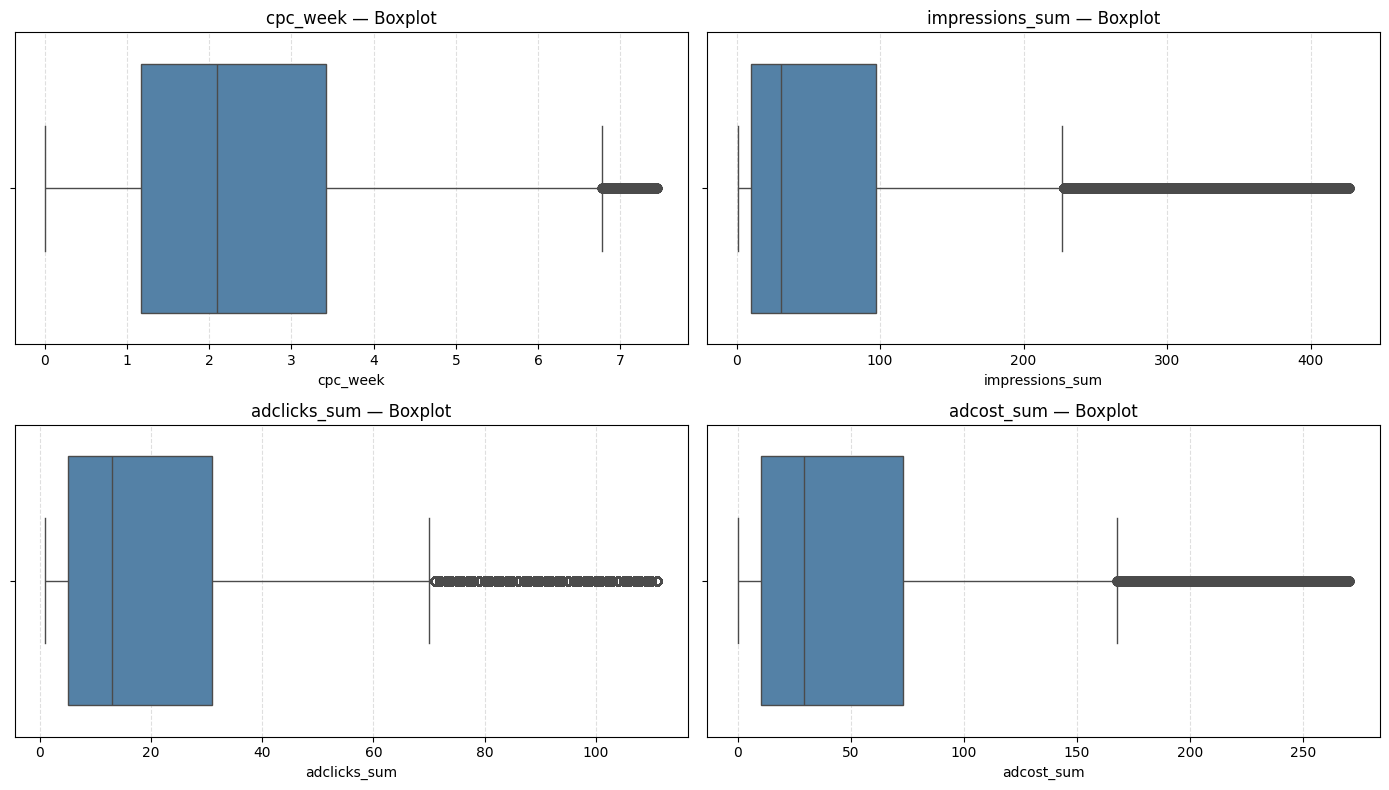

In [ ]:
import matplotlib.pyplot as plt

# ========= GROUP 1 – cpc_week, impressions_sum, adclicks_sum, adcost_sum =========
cols1 = ["cpc_week", "impressions_sum", "adclicks_sum", "adcost_sum"]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # <--- flatten 2x2 array into 1D list of Axes

for col, ax in zip(cols1, axes):
    trimmed_boxplot(df_parquet, col, ax)

plt.tight_layout()
plt.show()


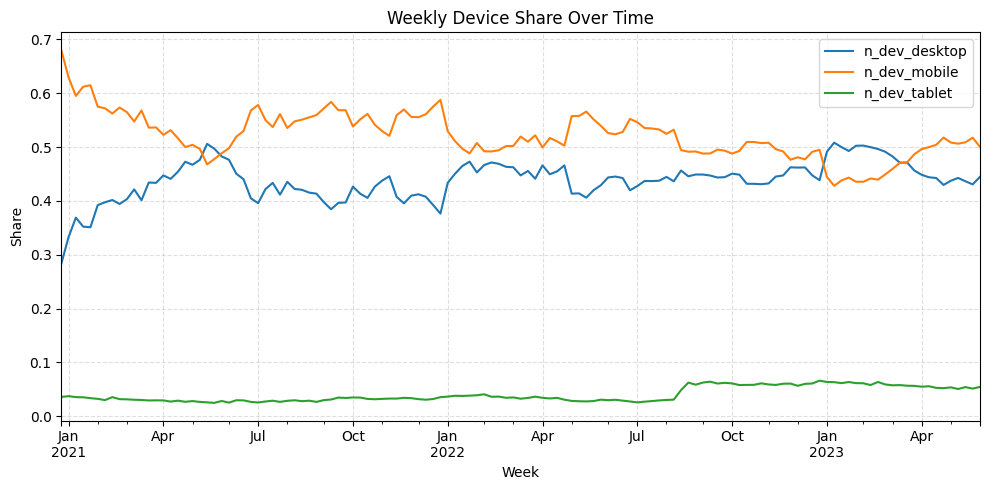

In [ ]:
device_weekly = df_parquet.groupby("week_dt")[[
    "n_dev_desktop", "n_dev_mobile", "n_dev_tablet"
]].sum()

device_share_weekly = device_weekly.div(device_weekly.sum(axis=1), axis=0)

plt.figure(figsize=(10,5))
device_share_weekly.plot(ax=plt.gca())

plt.title("Weekly Device Share Over Time")
plt.ylabel("Share")
plt.xlabel("Week")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


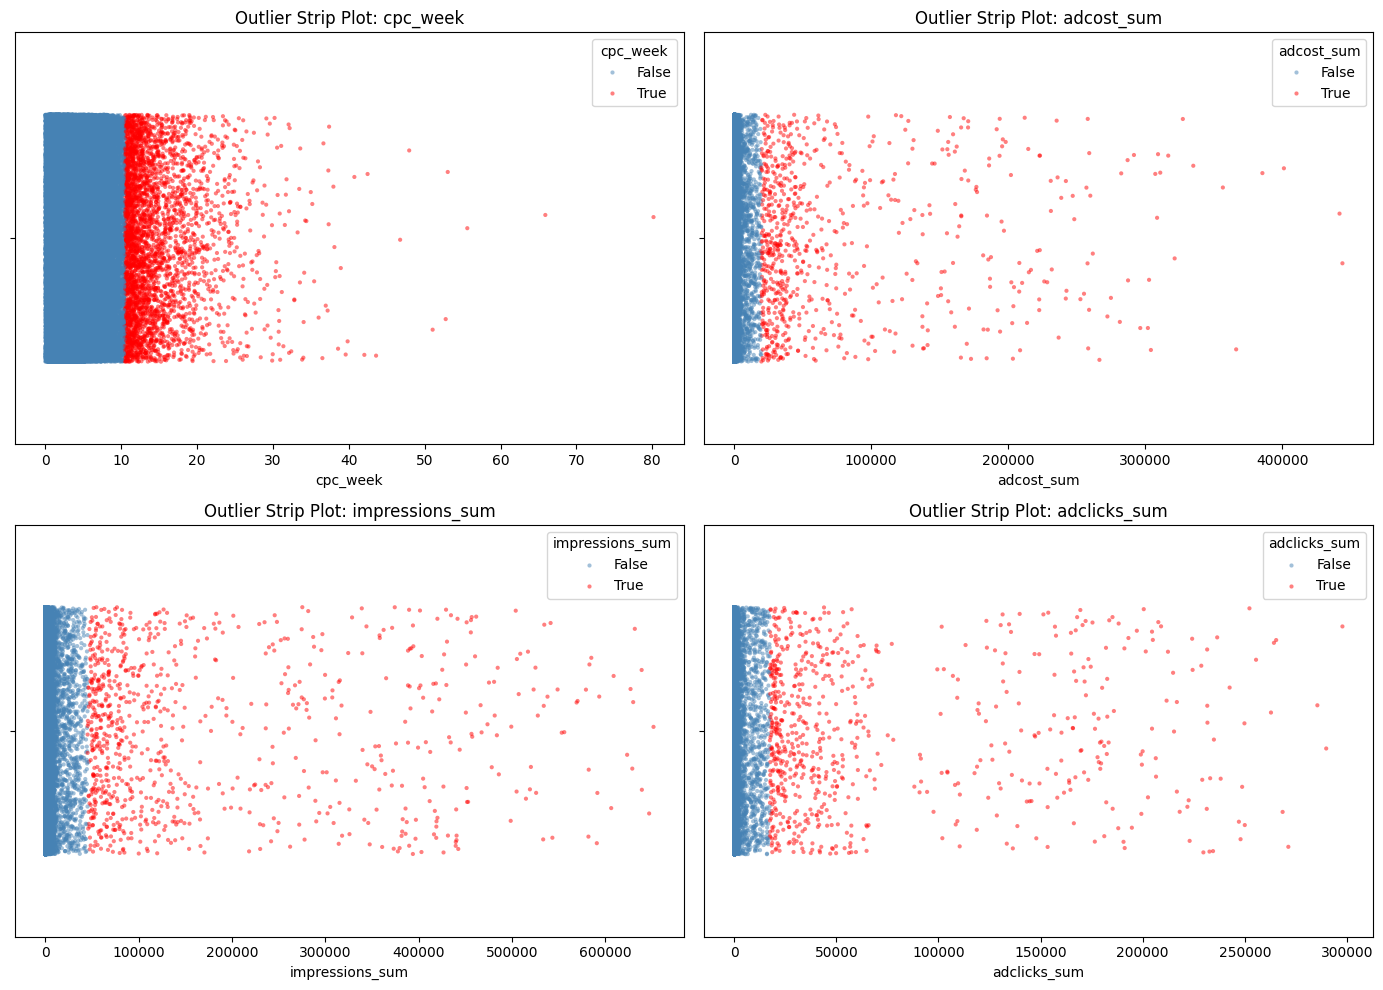

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

vars_outliers = ["cpc_week", "adcost_sum", "impressions_sum", "adclicks_sum"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for col, ax in zip(vars_outliers, axes):
    x = df_parquet[col]
    z = (x - x.mean()) / x.std()

    sns.stripplot(
        x=x,
        hue=z > 3,        # highlight extreme outliers (Z > 3)
        palette=["steelblue", "red"],
        ax=ax,
        alpha=0.5,
        jitter=0.3,
        size=3
    )

    ax.set_title(f"Outlier Strip Plot: {col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


In [ ]:
df_parquet[["impressions_sum","adclicks_sum","adcost_sum","cpc_week"]].describe(percentiles=[0.9, 0.95, 0.99])


,impressions_sum,adclicks_sum,adcost_sum,cpc_week
count,218924.000000,218924.000000,218924.000000,218924.000000
mean,1097.662865,338.494916,457.780410,2.862681
std,14748.405888,5694.465733,6421.684186,2.537436
min,1.000000,1.000000,0.007060,0.007060
50%,44.000000,16.000000,37.662979,2.197443
90%,611.000000,131.000000,346.908143,5.718520
95%,1415.000000,252.000000,699.764690,7.356866
99%,10265.080000,1981.310000,3425.060051,12.129683
max,651814.000000,297789.000000,443869.947868,80.160004


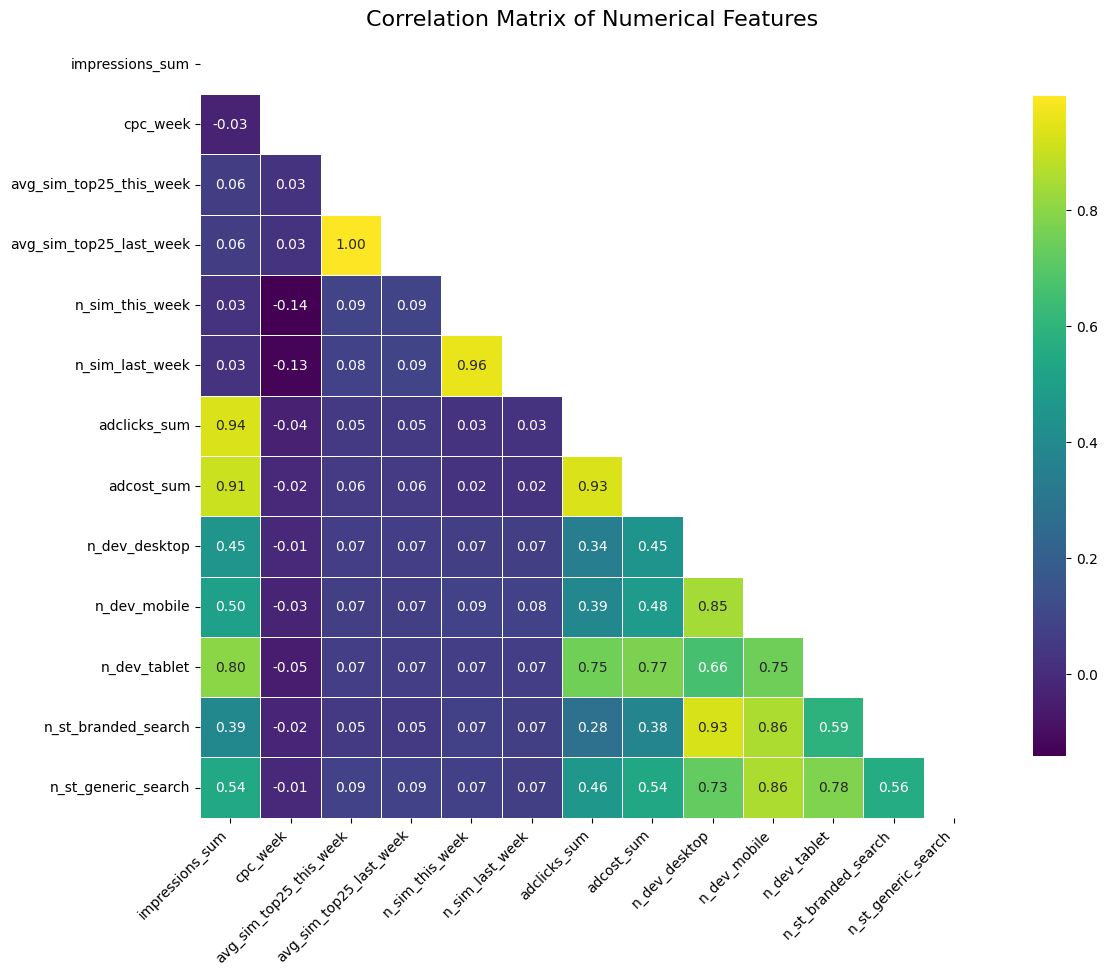

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 1. SELECT ONLY NUMERICAL COLUMNS =====
num_df = df_parquet.select_dtypes(include=[np.number])

# ===== 2. COMPUTE CORRELATION MATRIX =====
corr = num_df.corr()

# ===== 3. CREATE MASK FOR LOWER TRIANGLE =====
mask = np.triu(np.ones_like(corr, dtype=bool))

# ===== 4. PLOT (LIKE THE EXAMPLE) =====
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True
)

plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## EDA aggregated per keyword

In [ ]:
import pandas as pd
import numpy as np

# Variables
num_vars = [
    "cpc_week", "impressions_sum", "adclicks_sum", "adcost_sum",
    "n_dev_desktop", "n_dev_mobile", "n_dev_tablet",
    "avg_sim_top25_this_week", "avg_sim_top25_last_week",
    "n_st_branded_search", "n_st_generic_search"
]

# Keyword-level mean and std
kw_means = df_parquet.groupby("keyword")[num_vars].mean()
kw_stds  = df_parquet.groupby("keyword")[num_vars].std()

# Keyword-level coef_var
kw_cv = kw_stds / kw_means.replace(0, np.nan)

# Build the insightful table
insight_table = pd.DataFrame({
    "mean_of_means": kw_means.mean(),
    "std_of_means": kw_means.std(),
    "mean_of_coef_var": kw_cv.mean(),
    "std_of_coef_var": kw_cv.std()
}).round(4)

insight_table


,mean_of_means,std_of_means,mean_of_coef_var,std_of_coef_var
cpc_week,2.8685,1.8268,0.5047,0.1568
impressions_sum,1050.6095,13180.3800,1.0888,0.4718
adclicks_sum,323.5652,5060.1937,0.8650,0.3456
adcost_sum,439.4512,5455.5315,1.0020,0.3660
n_dev_desktop,20.1645,117.6365,0.8488,0.3164
n_dev_mobile,24.4595,138.4126,0.9004,0.4882
n_dev_tablet,1.6636,10.1216,2.3320,1.2561
avg_sim_top25_this_week,0.5836,0.0865,0.0213,0.0089
avg_sim_top25_last_week,0.5836,0.0865,0.0214,0.0090
n_st_branded_search,18.7277,155.8369,2.1462,2.1048


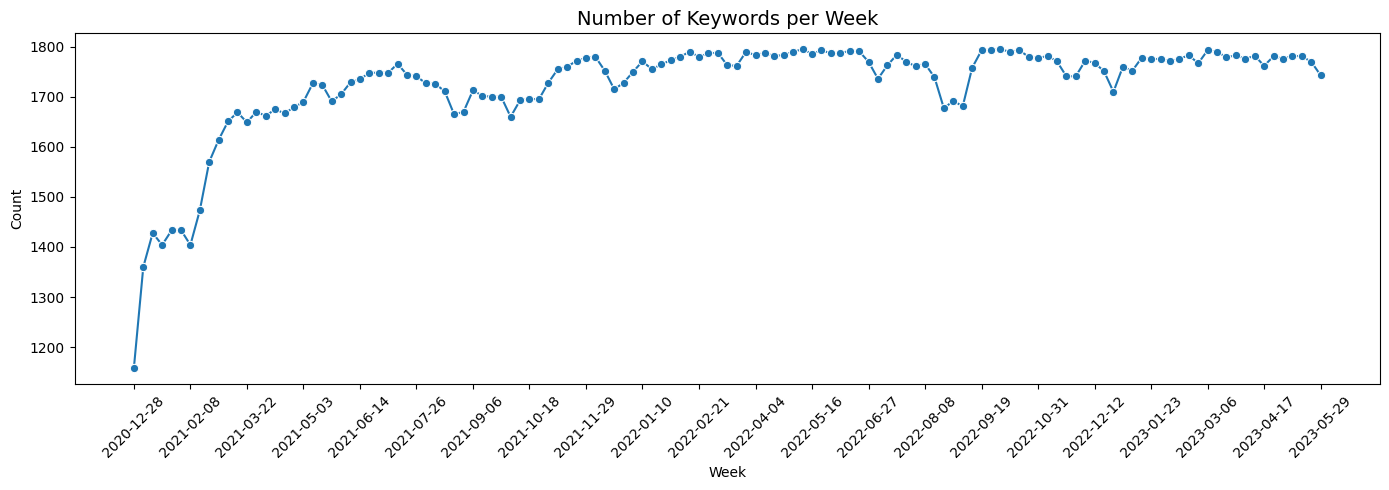

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 1. CONVERT WEEK STRING TO REAL DATETIME =====
# week format is "WW-YYYY" → convert to "YYYY-WW-1" meaning Monday of that ISO week
df_parquet["week_str"] = df_parquet["week"].apply(lambda w: f"{w.split('-')[1]}-W{w.split('-')[0]}-1")
df_parquet["week_dt"] = pd.to_datetime(df_parquet["week_str"], format="%G-W%V-%u")

# ===== 2. COUNT ROWS PER WEEK IN CHRONO ORDER =====
week_counts = (
    df_parquet.groupby("week_dt")
              .size()
              .reset_index(name="n_keywords")
              .sort_values("week_dt")
)

# ===== 3. CLEAN LINE PLOT WITH FEWER X-TICKS =====
plt.figure(figsize=(14,5))
sns.lineplot(
    data=week_counts,
    x="week_dt",
    y="n_keywords",
    marker="o"
)

plt.title("Number of Keywords per Week", fontsize=14)
plt.xlabel("Week")
plt.ylabel("Count")

# Show only every 6th week label (or adjust as needed)
plt.xticks(week_counts["week_dt"][::6], rotation=45)

plt.tight_layout()
plt.show()


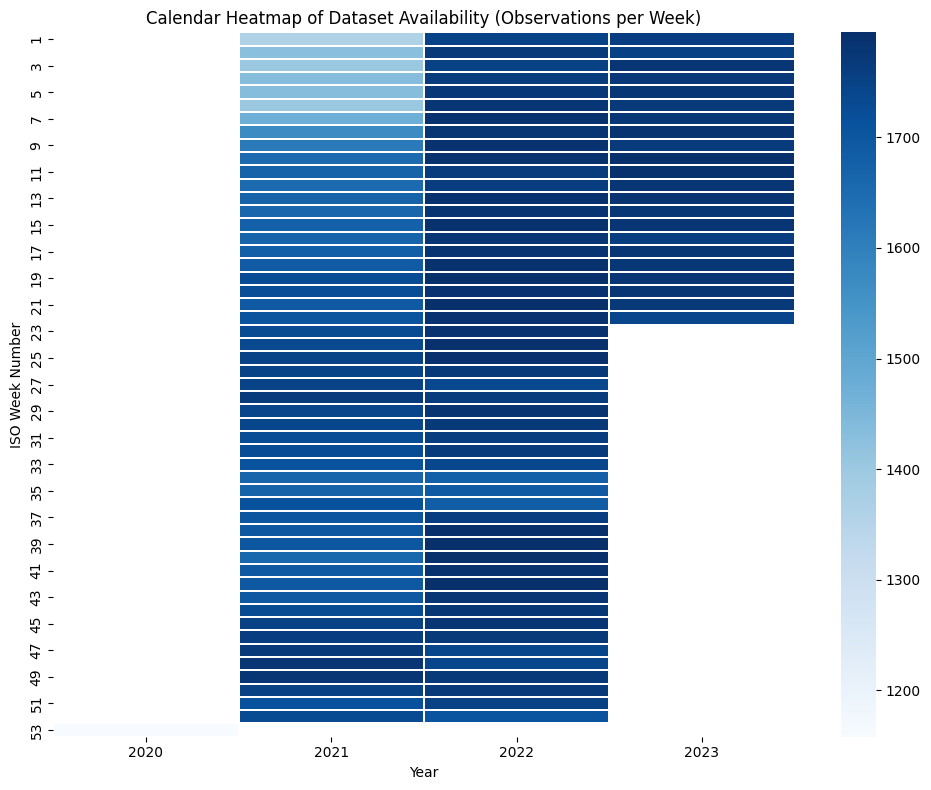

In [ ]:
df_calendar = df_parquet.groupby("week_dt").size().reset_index(name="count")
df_calendar["year"] = df_calendar["week_dt"].dt.year
df_calendar["week"] = df_calendar["week_dt"].dt.isocalendar().week

pivot_cal = df_calendar.pivot(index="week", columns="year", values="count")

plt.figure(figsize=(10,8))
sns.heatmap(pivot_cal, cmap="Blues", linewidths=0.3)

plt.title("Calendar Heatmap of Dataset Availability (Observations per Week)")
plt.xlabel("Year")
plt.ylabel("ISO Week Number")
plt.tight_layout()
plt.show()


NameError: name 'pl' is not defined

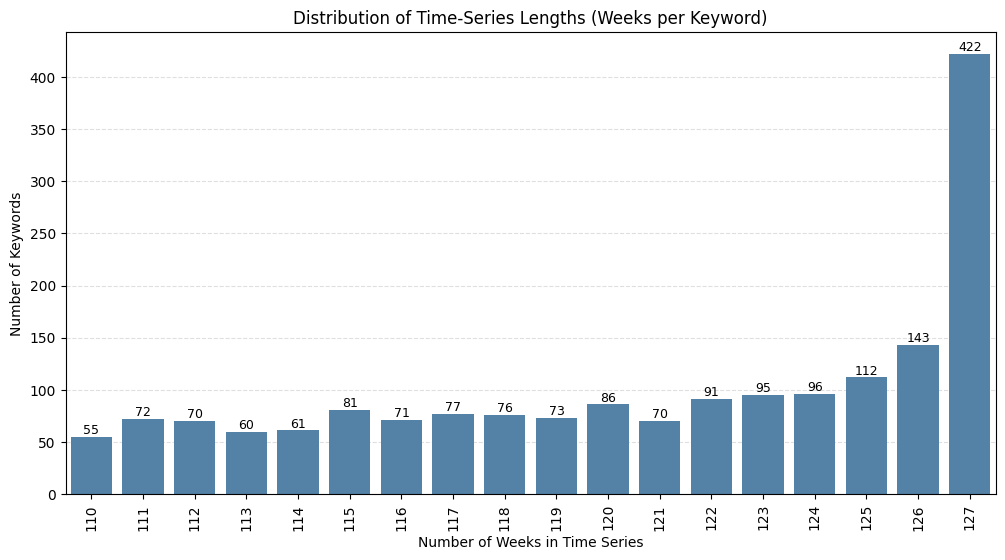

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== RECOMPUTE EVERYTHING =====

# 1. Count number of weeks per keyword
keyword_lengths = (
    df_parquet.groupby("keyword")["week_dt"]
              .nunique()
              .reset_index(name="n_weeks")
)

# 2. Count how many keywords have each series length
length_distribution = (
    keyword_lengths.groupby("n_weeks")
                   .size()
                   .reset_index(name="n_keywords")
                   .sort_values("n_weeks", ascending=False)
)

# ===== 3. PLOT WITH GRID + LABELS =====
plt.figure(figsize=(12,6))

ax = sns.barplot(
    data=length_distribution,
    x="n_weeks",
    y="n_keywords",
    color="steelblue"
)

# Add labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom', fontsize=9
    )

# Add grid (y-axis for readability)
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

plt.title("Distribution of Time-Series Lengths (Weeks per Keyword)")
plt.xlabel("Number of Weeks in Time Series")
plt.ylabel("Number of Keywords")
plt.xticks(rotation=90)
pl


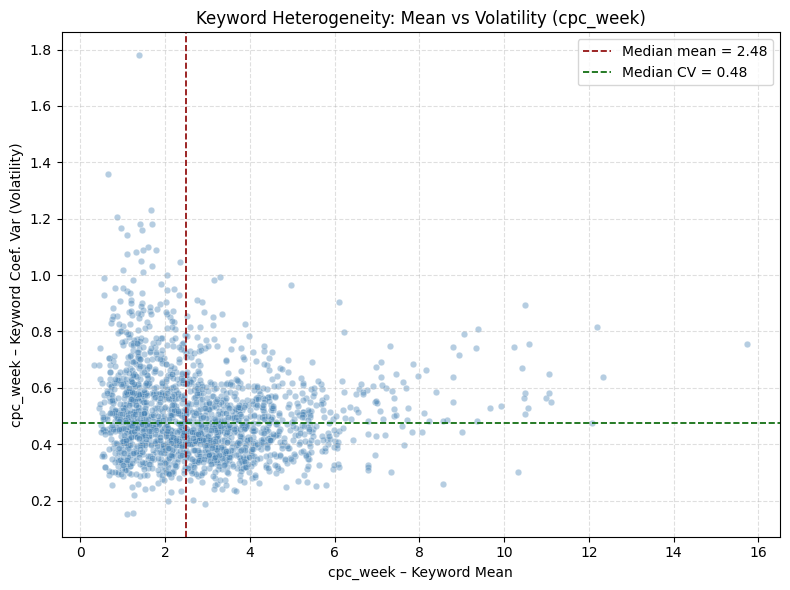

In [ ]:
# ============================
# 2) Plot: Volatility vs Mean WITH LINES
# ============================

var = "cpc_week"   # <-- change here to plot another variable

x_vals = keyword_means[var]
y_vals = keyword_coef_var[var]

# Reference lines
x_ref = x_vals.median()   # or x_vals.mean()
y_ref = y_vals.median()   # or y_vals.mean()

plt.figure(figsize=(8,6))

sns.scatterplot(
    x=x_vals,
    y=y_vals,
    alpha=0.4,
    s=22,
    color="steelblue"
)

# Add vertical quadrant line
plt.axvline(x=x_ref, color="darkred", linestyle="--", linewidth=1.2, label=f"Median mean = {x_ref:.2f}")

# Add horizontal quadrant line
plt.axhline(y=y_ref, color="darkgreen", linestyle="--", linewidth=1.2, label=f"Median CV = {y_ref:.2f}")

plt.xlabel(f"{var} – Keyword Mean")
plt.ylabel(f"{var} – Keyword Coef. Var (Volatility)")
plt.title(f"Keyword Heterogeneity: Mean vs Volatility ({var})")

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

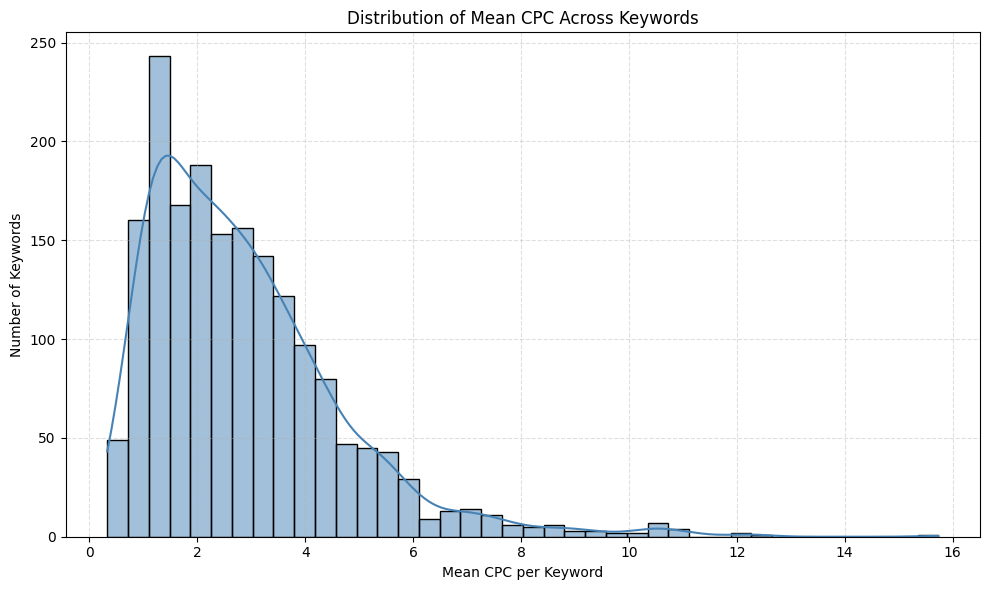

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute keyword-level mean CPC
cpc_keyword_mean = keyword_means["cpc_week"]

plt.figure(figsize=(10,6))
sns.histplot(
    cpc_keyword_mean,
    bins=40,
    kde=True,
    color="steelblue"
)

plt.title("Distribution of Mean CPC Across Keywords")
plt.xlabel("Mean CPC per Keyword")
plt.ylabel("Number of Keywords")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
